In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time, ast, os
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 50)
START_POI = 1
END_POI = 301
START_DATE = '2018-12-31'
TOTAL_DAYS = 400
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)
WINDOW_SIZE = 24
HORIZON = 6

In [3]:
class bounding_box:
    def __init__(self, _lat_min, _lon_min,_lat_max,_lon_max):
        self.lat_min = _lat_min
        self.lon_min = _lon_min
        self.lat_max = _lat_max
        self.lon_max = _lon_max


class stat_collector:
    def __init__(self):
        self.parquet_file_count=0
        self.data_record_count = 0
        self.memory_usage_in_GB = 0		#gives an estimate of the total RAM usage if all files were read into memory at the same time.
        self.unique_device_count = 0
        self.avg_pos_acc = 0
        self.starting_time = time.process_time()
        self.elapsed_time = time.process_time()
        self.unique_geohash_count = 0
        
def load_poi_db(HT_range=0.2, ht_lat=29.749907, ht_lon=-95.358421):
    HT_box = bounding_box(ht_lat - HT_range, ht_lon - HT_range, ht_lat + HT_range, ht_lon + HT_range)

    bbox = HT_box
    poi_folder = "/storage/dataset/poi_haowen/CoreRecords-CORE_POI-2019_03-2020-03-25/"
    poi_columns = ["safegraph_place_id", "parent_safegraph_place_id", "location_name", "safegraph_brand_ids", "brands",
                   "top_category", "sub_category", "naics_code", "latitude", "longitude", "street_address", "city",
                   "region", "postal_code", "iso_country_code", "phone_number", "open_hours", "category_tags"]
    files = os.listdir(poi_folder)


    poi_s = stat_collector()
    poi_db = pd.DataFrame(columns=poi_columns)
    for f in files:
        if f[-3:] == 'csv' and 'brand' not in f:
            print(f)
            df = pd.read_csv(poi_folder + f)
            df = df[
                (df['latitude'] > bbox.lat_min) & (df['latitude'] < bbox.lat_max) & (df['longitude'] > bbox.lon_min) & (
                            df['longitude'] < bbox.lon_max)]
            poi_db = poi_db.append(df, ignore_index=True, sort=False)
            poi_s.memory_usage_in_GB += df.memory_usage(deep=True).sum() / 1000000000
            poi_s.data_record_count += df.shape[0]
            poi_s.parquet_file_count += 1
    return poi_db, poi_s


def get_merged_df(csv_path, start_row, end_row):

    #start = time.time()
    merge_df = pd.read_csv(csv_path)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.iloc[start_row:end_row]
    #print(merge_df)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: x[:TOTAL_DAYS*24])
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: x[:TOTAL_DAYS])
    return merge_df


In [4]:
def masked_MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    
    mask = (v < 1E-5)
    percentage = np.abs(v_ - v) / np.abs(v)
    percentage = np.where(percentage > 5, 5, percentage) # TODO remove this
    if np.any(mask):
        masked_array = np.ma.masked_array(percentage, mask=mask)  # mask the dividing-zero as invalid
        result = masked_array.mean(axis=axis)
        if isinstance(result, np.ma.MaskedArray):
            return result.filled(np.nan)
        else:
            return result
    return np.mean(percentage, axis).astype(np.float64)


def MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    mape = (np.abs(v_ - v) / np.abs(v)+1e-5).astype(np.float64)
    mape = np.where(mape > 5, 5, mape)
    return np.mean(mape, axis)


def RMSE(v, v_, axis=None):
    '''
    Mean squared error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, RMSE averages on all elements of input.
    '''
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)




def MAE(v, v_, axis=None):
    '''
    Mean absolute error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAE averages on all elements of input.
    '''

    return np.mean(np.abs(v_ - v), axis).astype(np.float64)


def evaluate(y, y_hat, by_step=False, by_node=False):
    '''
    :param y: array in shape of [count, time_step, node].
    :param y_hat: in same shape with y.
    :param by_step: evaluate by time_step dim.
    :param by_node: evaluate by node dim.
    :return: array of mape, mae and rmse.
    '''
    if not by_step and not by_node:
        return masked_MAPE(y, y_hat), MAE(y, y_hat), RMSE(y, y_hat)
    if by_step and by_node:
        return masked_MAPE(y, y_hat, axis=0), MAE(y, y_hat, axis=0), RMSE(y, y_hat, axis=0)
    if by_step:
        return masked_MAPE(y, y_hat, axis=(0, 2)), MAE(y, y_hat, axis=(0, 2)), RMSE(y, y_hat, axis=(0, 2))
    if by_node:
        return masked_MAPE(y, y_hat, axis=(0, 1)), MAE(y, y_hat, axis=(0, 1)), RMSE(y, y_hat, axis=(0, 1))

In [5]:
csv_path_weekly = '/home/users/arash/datasets/safegraph/weekly_patterns_2018-12-31_2020-06-08_Houston.csv'
csv_poi_info = '/home/users/arash/datasets/safegraph/core_poi_info_2018-12-31_2020-06-08.csv'
weekly_patterns = get_merged_df(csv_path_weekly, START_POI, END_POI)
poi_info = pd.read_csv(csv_poi_info)
poi_df = pd.merge(weekly_patterns, poi_info, on='safegraph_place_id', how='inner')
poi_df.head(3)

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands
0,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN
1,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall
2,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN


In [6]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
valid_dates

array(['2019-10-08T00:00:00.000000000', '2019-10-08T01:00:00.000000000',
       '2019-10-08T02:00:00.000000000', ...,
       '2019-12-25T16:00:00.000000000', '2019-12-25T17:00:00.000000000',
       '2019-12-25T18:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
poi_db, poi_s = load_poi_db(HT_range=1.5)
poi_df = poi_df.merge(poi_db, how='left', on='safegraph_place_id', suffixes=('', '_y'))
poi_df.drop(poi_df.filter(regex='_y$').columns, axis=1, inplace=True)
del poi_db
poi_df.head(3)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN
1,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN
2,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN,sg:7dea7a58e8424b22ba0d0b96bc1b6cc9,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,29.986670,-95.337942,NaN,NaN,NaN


In [9]:
poi_df['visits_by_each_hour'] = poi_df['visits_by_each_hour'].apply(lambda x: np.array(x))
poi_df['visits_by_day'] = poi_df['visits_by_day'].apply(lambda x: np.array(x))
agg_df = poi_df.groupby('top_category').agg({'visits_by_day': 'sum',
                                    'visits_by_each_hour': 'sum',
                                    'raw_visit_counts': 'sum',
                                    'safegraph_place_id': 'count'})
agg_df.columns = ['daily_visits', 'hourly_visits', 'raw_visits', 'count']
agg_df.head()

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Automobile Dealers,"[302, 219, 211, 194, 266, 319, 185, 125, 121, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 19, 33, 22, 48,...",85495,1
Book Stores and News Dealers,"[5, 5, 35, 38, 84, 15, 9, 44, 121, 90, 113, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...",119990,1
Building Material and Supplies Dealers,"[568, 403, 492, 505, 638, 660, 582, 435, 546, ...","[4, 0, 0, 1, 4, 5, 8, 17, 21, 38, 61, 65, 53, ...",373987,5
Child Day Care Services,"[88, 26, 194, 163, 199, 116, 355, 602, 1318, 1...","[0, 0, 0, 2, 2, 3, 4, 3, 9, 7, 6, 14, 11, 5, 6...",349982,4
Clothing Stores,"[103, 14, 177, 192, 235, 10, 6, 239, 261, 264,...","[0, 0, 0, 1, 0, 1, 5, 21, 9, 11, 9, 14, 4, 9, ...",83320,1


In [10]:
agg_df.loc[agg_df['count'] == 2]

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Furniture Stores,"[491, 404, 360, 351, 445, 602, 617, 284, 219, ...","[0, 0, 1, 1, 1, 0, 3, 5, 6, 17, 47, 42, 49, 64...",196754,2
Other Information Services,"[4, 2, 57, 72, 58, 10, 6, 63, 100, 88, 90, 96,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, ...",153784,2


In [11]:
def get_df_timeseries(df, category, time_index=time_span):
    tmp_df = pd.DataFrame(df.loc[category]).T
    ts_df = tmp_df.explode(['hourly_visits']).set_index(time_index)[['hourly_visits']].rename(columns=dict(hourly_visits='visits'))
    return ts_df

In [12]:
def get_preds_timeseries(df, category, time_index):
    tmp_df = pd.DataFrame(df.loc[category]).T
    ts_df = tmp_df.explode(['predictions']).set_index(time_index)[['predictions']].rename(columns=dict(predictions='visits'))
    return ts_df

In [13]:
get_df_timeseries(agg_df, 'Home Health Care Services')

,visits
2018-12-31 00:00:00,2
2018-12-31 01:00:00,5
2018-12-31 02:00:00,4
2018-12-31 03:00:00,1
2018-12-31 04:00:00,5
...,...
2020-02-03 19:00:00,5
2020-02-03 20:00:00,4
2020-02-03 21:00:00,6
2020-02-03 22:00:00,5


In [14]:
agg_df.sort_values(by='raw_visits', ascending=False)

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Lessors of Real Estate,"[33369, 21432, 25749, 29581, 34538, 35409, 292...","[123, 83, 76, 82, 120, 165, 227, 465, 738, 127...",15381086,104
Support Activities for Air Transportation,"[7283, 7904, 9670, 8743, 8648, 7241, 9292, 655...","[83, 97, 101, 140, 300, 353, 364, 361, 414, 51...",3878370,6
"General Merchandise Stores, including Warehouse Clubs and Supercenters","[5972, 3299, 4440, 5382, 5535, 6002, 5803, 448...","[59, 35, 26, 25, 32, 44, 75, 82, 148, 255, 376...",3053969,26
Restaurants and Other Eating Places,"[4081, 2119, 5111, 5650, 5680, 3135, 2975, 490...","[32, 43, 32, 32, 33, 78, 285, 312, 265, 260, 2...",2791243,23
Elementary and Secondary Schools,"[1163, 495, 1753, 1850, 2418, 1278, 1745, 3043...","[7, 10, 11, 4, 7, 21, 80, 121, 113, 118, 105, ...",2638096,20
Gasoline Stations,"[3250, 3339, 4782, 4506, 4320, 3500, 3820, 357...","[24, 24, 15, 36, 75, 113, 168, 195, 270, 151, ...",2030970,8
Traveler Accommodation,"[3569, 3639, 4412, 4221, 4116, 3960, 4025, 330...","[37, 21, 16, 42, 81, 114, 163, 194, 261, 141, ...",1972533,8
General Medical and Surgical Hospitals,"[1500, 1121, 2707, 3067, 2874, 1333, 1320, 257...","[19, 20, 14, 27, 19, 32, 113, 94, 83, 80, 81, ...",1401609,8
"Museums, Historical Sites, and Similar Institutions","[1328, 1213, 1138, 1400, 1885, 8570, 1554, 123...","[5, 5, 4, 5, 7, 11, 32, 46, 59, 77, 98, 120, 1...",1211919,10


### Checking Total Visits Volume

### Checking the Prediction Visit Pattersn

In [15]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
start_time, end_time

(datetime.datetime(2018, 12, 31, 0, 0), datetime.datetime(2020, 2, 4, 0, 0))

In [16]:
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

In [18]:
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
valid_dates

array(['2019-10-08T00:00:00.000000000', '2019-10-08T01:00:00.000000000',
       '2019-10-08T02:00:00.000000000', ...,
       '2019-12-25T16:00:00.000000000', '2019-12-25T17:00:00.000000000',
       '2019-12-25T18:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
pred_saved_path = f'/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_{START_POI}_{END_POI}'
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',').T
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',').T

In [20]:
preds_df = poi_df.copy()
preds_df['predictions'] = pd.Series(list(preds_data))
preds_df['targets'] = pd.Series(list(target_data))
preds_df

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags,predictions,targets
0,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN,"[16.731768004189163, 20.225676550224236, 26.45...","[13.99999700030996, 2.9999957145460883, 2.9999..."
1,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN,"[4.427609900799325, 4.2011581373243985, 6.7757...","[10.000000323686933, 8.999996763705909, 4.9999..."
2,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN,sg:7dea7a58e8424b22ba0d0b96bc1b6cc9,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,29.986670,-95.337942,NaN,NaN,NaN,"[13.37797024449219, 19.956196900438144, 22.141...","[5.999998899377957, 2.999999281921859, 2.99999..."
3,sg:360d88ef2ced4be180ea24290b9f9df4,"[2410, 2607, 3235, 2913, 2806, 2217, 3011, 217...","[28, 45, 53, 36, 94, 116, 104, 132, 103, 189, ...",1240632,William P Hobby Airport,7800 Airport Blvd,Houston,TX,77061,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.646145,-95.277014,1.713640e+10,NaN,NaN,"[34.129026878164154, 23.863704339252237, 27.66...","[22.999996172017575, 7.999996106306341, 11.999..."
4,sg:97332bde5ea043d6ac3cfa2fdfe63403,"[2771, 2348, 2462, 2606, 2995, 3433, 2037, 146...","[4, 2, 0, 1, 1, 9, 7, 31, 45, 68, 152, 265, 34...",975482,Bally Fitness Center Shopping Center,9801 Katy Fwy,Houston,TX,77024,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,29.781627,-95.540084,NaN,NaN,NaN,"[0.29736903670975323, -0.7082270762078338, -2....","[5.853409845713031e-08, 1.9999999376679227, 5...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,sg:d1cc1fc0e9cd426da2694912b3d85d1e,"[136, 73, 75, 93, 94, 86, 107, 87, 75, 79, 82,...","[1, 0, 0, 1, 0, 0, 1, 2, 0, 7, 6, 13, 11, 10, ...",58266,Kroger,14710 Woodforest Blvd,Houston,TX,77015,US,SG_BRAND_1f852a23da4b7250,Kroger,NaN,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,29.789640,-95.159284,1.713453e+10,NaN,NaN,"[0.14893229436643196, 0.024322677963430905, -0...","[1.854704114734318e-07, 1.854704114734318e-07,..."
296,sg:e3d36507e3a34ad2aaacbfad83ce9863,"[165, 121, 96, 124, 130, 126, 159, 71, 100, 98...","[0, 1, 1, 0, 0, 0, 1, 3, 11, 11, 11, 16, 17, 1...",58206,Target,6955 Highway 6 N,Houston,TX,77084,US,SG_BRAND_42aefbae01d2dfd981f7da7d823d689e,Target,sg:8cf41d0cc2ec4b9e924adbf4545085c7,Department Stores,Department Stores,452210.0,29.877339,-95.647496,NaN,"{ ""Mon"": [[""8:00"", ""23:00""]], ""Tue"": [[""8:00"",...",NaN,"[0.03913675554190821, -0.03297555370720584, -0...","[1.7834707044528386e-08, 1.7834707044528386e-0..."
297,sg:07f10bfebbe6458f9c237b9d0e4ac1a6,"[21, 2, 78, 83, 81, 72, 331, 81, 128, 110, 115...","[0, 0, 0, 0, 0, 0, 2, 0, 5, 0, 0, 4, 0, 1, 1, ...",58008,First Baptist Academy,7450 Memorial Woods Dr,Houston,TX,77024,US,NaN,NaN,NaN,Child Day C

In [21]:
preds_agg_df = preds_df.groupby('top_category').agg({'predictions': 'sum',
                                                   'targets': 'sum',
                                                   'visits_by_day': 'sum',
                                                    'visits_by_each_hour': 'sum',
                                                    'raw_visit_counts': 'sum',
                                                    'safegraph_place_id': 'count'})
preds_agg_df.columns = ['predictions', 'targets','daily_visits', 'hourly_visits', 'raw_visits', 'count']
preds_agg_df.head()

,predictions,targets,daily_visits,hourly_visits,raw_visits,count
top_category,,,,,,
Automobile Dealers,"[0.05816810059437039, 0.06607094314268824, 0.0...","[-1.715898898524415e-07, -1.715898898524415e-0...","[302, 219, 211, 194, 266, 319, 185, 125, 121, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 19, 33, 22, 48,...",85495,1
Book Stores and News Dealers,"[0.3641410728905523, 0.485560943314189, 0.2978...","[2.9359374131843197e-07, 2.9359374131843197e-0...","[5, 5, 35, 38, 84, 15, 9, 44, 121, 90, 113, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...",119990,1
Building Material and Supplies Dealers,"[1.5328289473900147, 1.7901244672861392, 2.680...","[2.850603859627654e-07, 2.850603859627654e-07,...","[568, 403, 492, 505, 638, 660, 582, 435, 546, ...","[4, 0, 0, 1, 4, 5, 8, 17, 21, 38, 61, 65, 53, ...",373987,5
Child Day Care Services,"[0.40847776589647466, 4.615958251830424, -3.08...","[-1.4064378728306792e-07, -1.4064378728306792e...","[88, 26, 194, 163, 199, 116, 355, 602, 1318, 1...","[0, 0, 0, 2, 2, 3, 4, 3, 9, 7, 6, 14, 11, 5, 6...",349982,4
Clothing Stores,"[0.702715665309241, 1.265323613826058, 1.52304...","[2.4239720453067548e-08, 0.999999883706967, 2....","[103, 14, 177, 192, 235, 10, 6, 239, 261, 264,...","[0, 0, 0, 1, 0, 1, 5, 21, 9, 11, 9, 14, 4, 9, ...",83320,1


In [22]:
total_visits_df = pd.DataFrame(agg_df['hourly_visits'].sum()).rename(columns={0:'visits'})
total_visits_df = total_visits_df.set_index(time_span)
total_visits_df

,visits
2018-12-31 00:00:00,427
2018-12-31 01:00:00,384
2018-12-31 02:00:00,332
2018-12-31 03:00:00,443
2018-12-31 04:00:00,741
...,...
2020-02-03 19:00:00,3411
2020-02-03 20:00:00,2122
2020-02-03 21:00:00,1260
2020-02-03 22:00:00,870


In [23]:
total_preds_visits_df = pd.DataFrame(preds_agg_df['predictions'].sum()).rename(columns={0:'visits'})
total_preds_visits_df = total_preds_visits_df.set_index(valid_dates)
total_preds_visits_df

,visits
2019-10-08 00:00:00,415.346113
2019-10-08 01:00:00,417.621785
2019-10-08 02:00:00,450.620610
2019-10-08 03:00:00,552.187760
2019-10-08 04:00:00,853.051511
...,...
2019-12-25 14:00:00,2185.112617
2019-12-25 15:00:00,2218.238263
2019-12-25 16:00:00,1983.536677
2019-12-25 17:00:00,1610.296200


In [24]:
def plot_agg_results(main_df, preds_df, name):
    plt.style.use('fivethirtyeight')
    #daily
    ax = main_df.resample('1D').sum().plot(figsize=(16, 8))
    preds_df.resample('1D').sum().plot(ax=ax)
    ax.legend(labels=('target', 'preds'))
    plt.title(f'Daily {name} Visits Number')
    plt.savefig(f"img/daily_visits_num_to_cat_{name}.png", bbox_inches = 'tight')
    
    #weekly
    ax = main_df.resample('1W').sum().plot(figsize=(16, 8))
    preds_df.resample('1W').sum().plot(ax=ax)
    ax.legend(labels=('target', 'preds'))
    plt.title(f'Weekly {name} Visits Number')
    plt.savefig(f"img/weekly_visits_num_to_cat_{name}.png", bbox_inches = 'tight')

    
    #monthly
    ax = main_df.resample('1M').sum().plot(figsize=(16, 8))
    preds_df.resample('1M').sum().plot(ax=ax)
    ax.legend(labels=('target', 'preds'))
    plt.title(f'Monthly {name} Visits Number')
    plt.savefig(f"img/monthly_visits_num_to_cat_{name}.png", bbox_inches = 'tight')


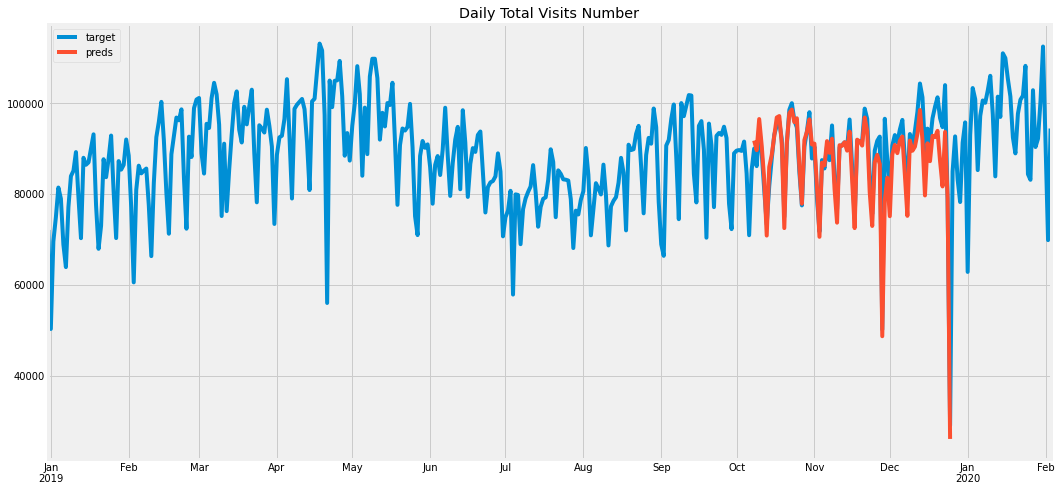

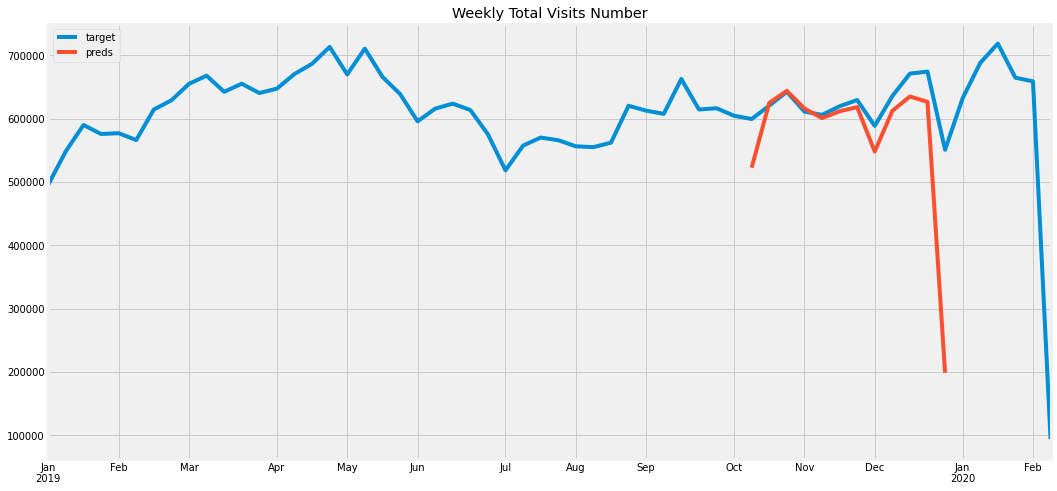

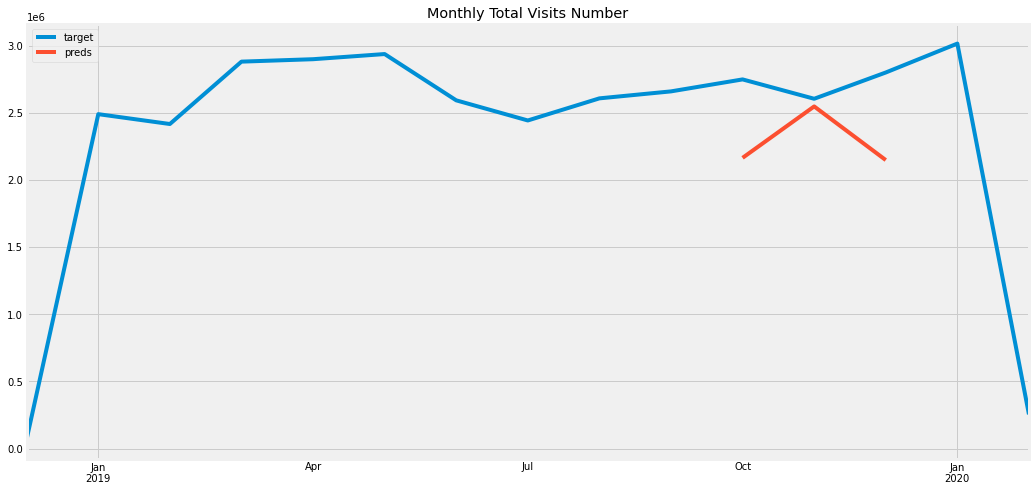

In [25]:
plot_agg_results(total_visits_df, total_preds_visits_df, 'Total')

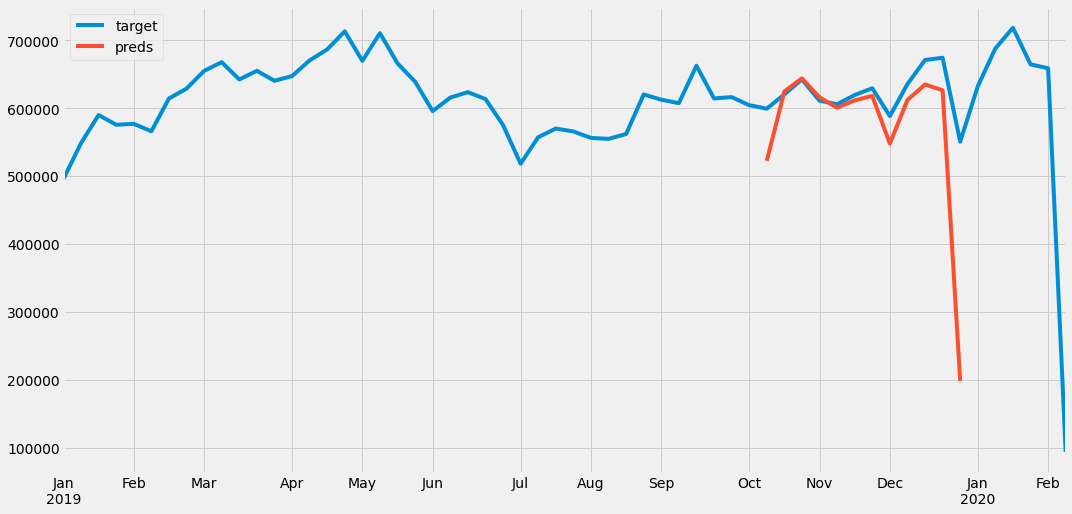

In [26]:
plt.style.use('fivethirtyeight')
ax = total_visits_df.resample('1W').sum().plot(figsize=(16, 8))
total_preds_visits_df.resample('1W').sum().plot(ax=ax)
ax.legend(labels=('target', 'preds'))

### Checking Grocery Stores' Patterns

In [27]:
groc_df = get_df_timeseries(agg_df, 'Grocery Stores')
groc_df

,visits
2018-12-31 00:00:00,6
2018-12-31 01:00:00,5
2018-12-31 02:00:00,10
2018-12-31 03:00:00,12
2018-12-31 04:00:00,24
...,...
2020-02-03 19:00:00,122
2020-02-03 20:00:00,66
2020-02-03 21:00:00,46
2020-02-03 22:00:00,38


In [28]:
preds_groc_df = get_preds_timeseries(preds_agg_df, 'Grocery Stores', valid_dates)
preds_groc_df

,visits
2019-10-08 00:00:00,6.179131
2019-10-08 01:00:00,5.583526
2019-10-08 02:00:00,5.362795
2019-10-08 03:00:00,9.159182
2019-10-08 04:00:00,19.969168
...,...
2019-12-25 14:00:00,25.579534
2019-12-25 15:00:00,26.961812
2019-12-25 16:00:00,24.335701
2019-12-25 17:00:00,16.982037


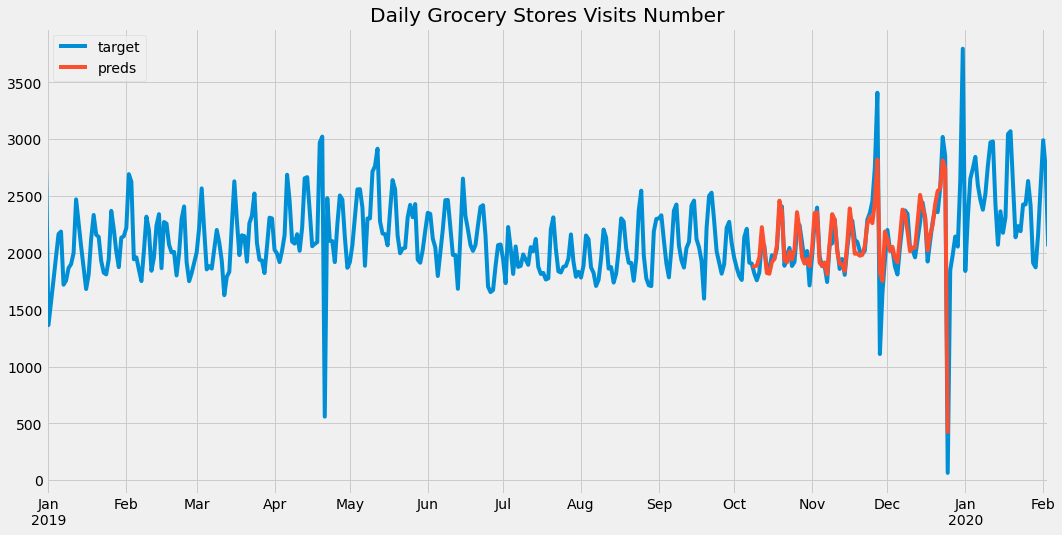

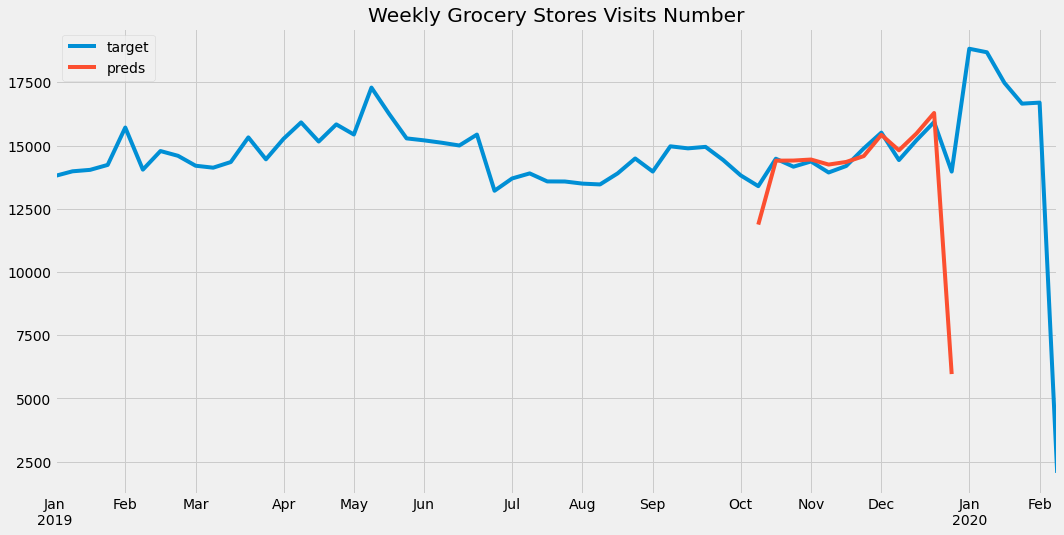

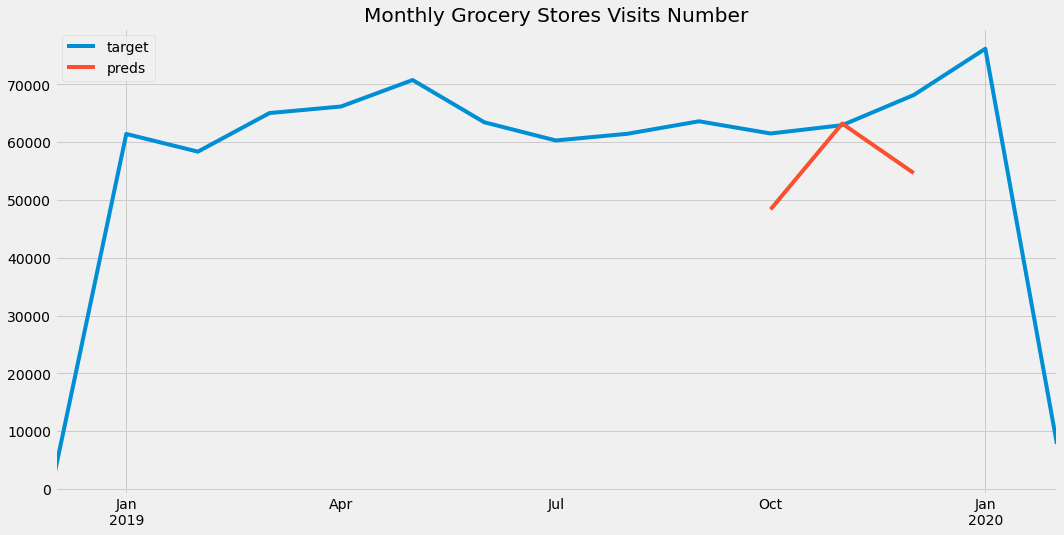

In [29]:
plot_agg_results(groc_df, preds_groc_df, 'Grocery Stores')

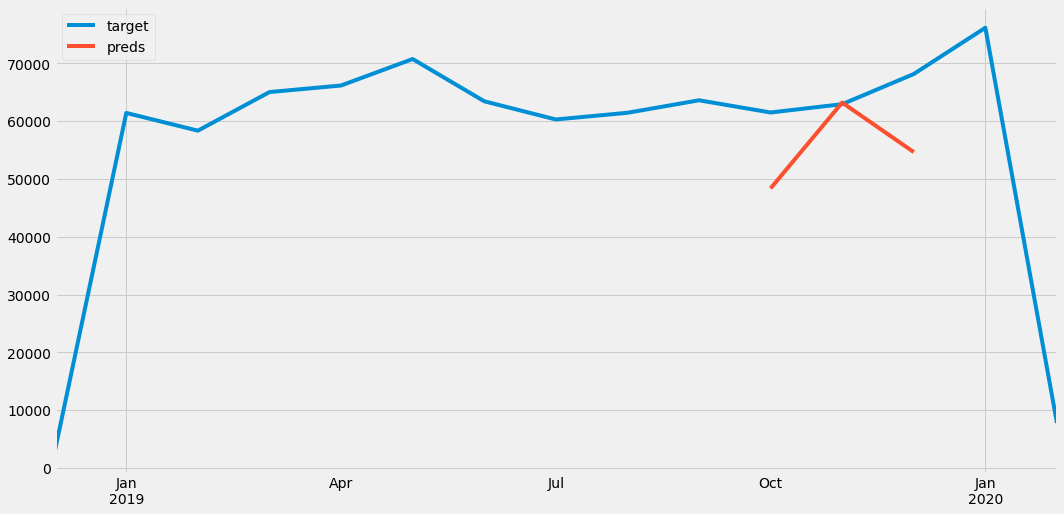

In [30]:
plt.style.use('fivethirtyeight')
ax = groc_df.resample('1M').sum().plot(figsize=(16, 8))
preds_groc_df.resample('1M').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

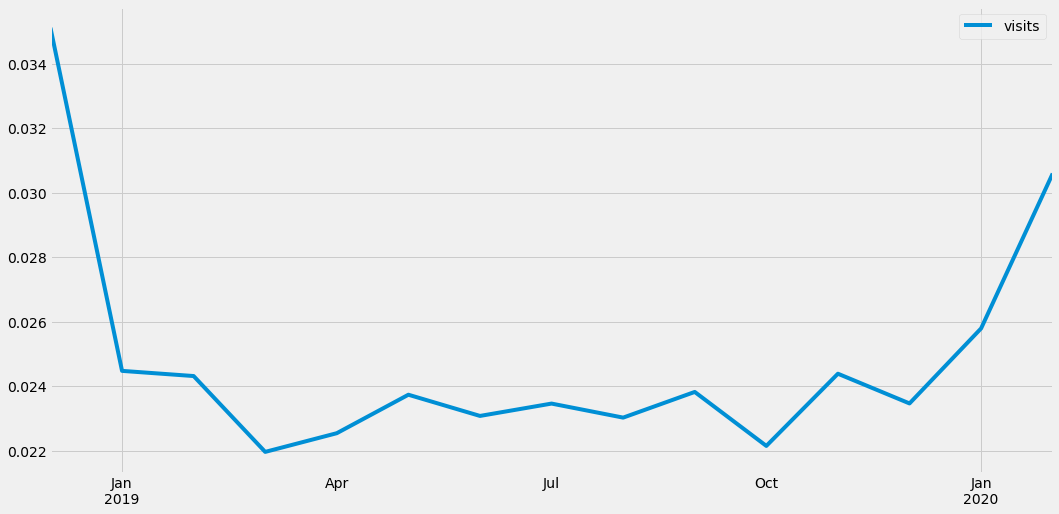

In [31]:
pd.DataFrame(groc_df['visits'] / total_visits_df['visits']).resample('1M').mean().plot(figsize=(16, 8))

### Checking Gas Stations' Patterns

In [32]:
gas_df = get_df_timeseries(agg_df, 'Gasoline Stations')
gas_df

,visits
2018-12-31 00:00:00,24
2018-12-31 01:00:00,24
2018-12-31 02:00:00,15
2018-12-31 03:00:00,36
2018-12-31 04:00:00,75
...,...
2020-02-03 19:00:00,164
2020-02-03 20:00:00,162
2020-02-03 21:00:00,55
2020-02-03 22:00:00,56


In [33]:
preds_gas_df = get_preds_timeseries(preds_agg_df, 'Gasoline Stations', valid_dates)
preds_gas_df

,visits
2019-10-08 00:00:00,22.46878
2019-10-08 01:00:00,26.981183
2019-10-08 02:00:00,35.304577
2019-10-08 03:00:00,37.204698
2019-10-08 04:00:00,71.634034
...,...
2019-12-25 14:00:00,182.841087
2019-12-25 15:00:00,189.968699
2019-12-25 16:00:00,179.548281
2019-12-25 17:00:00,154.628647


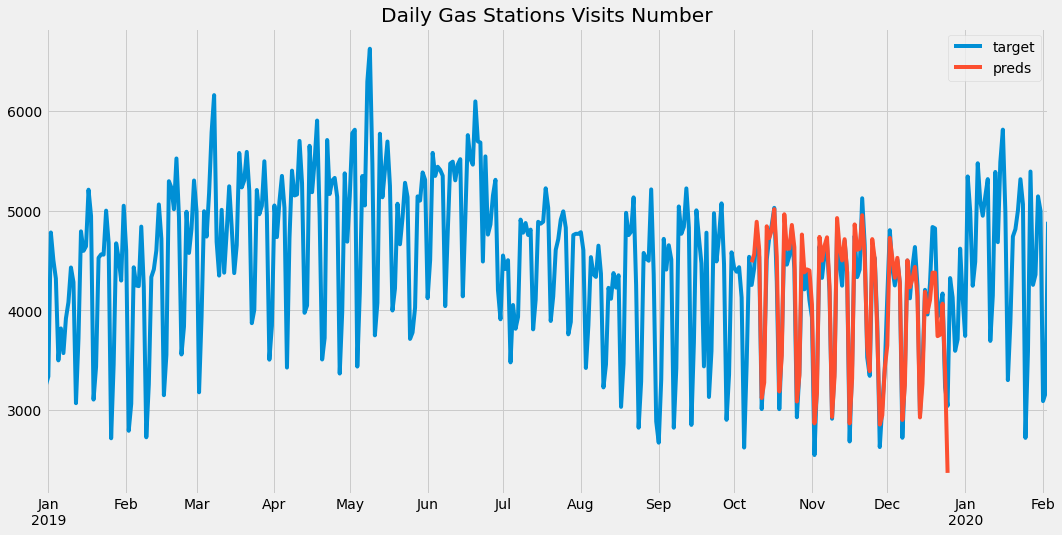

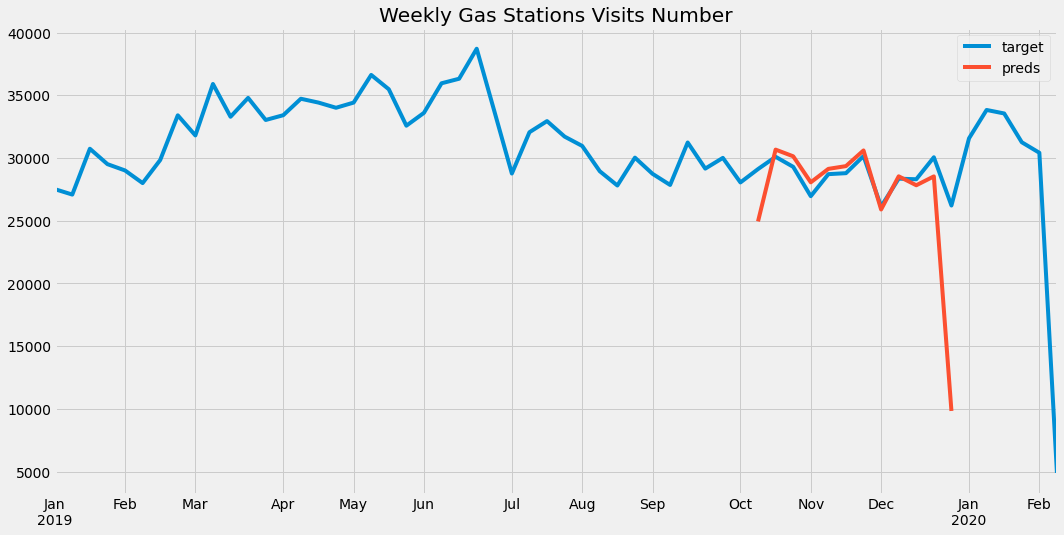

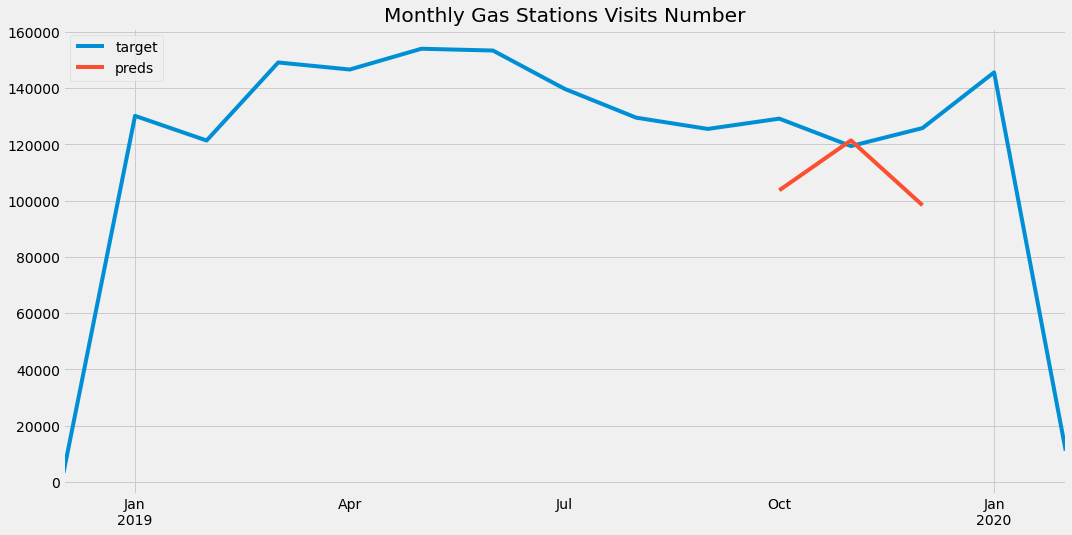

In [34]:
plot_agg_results(gas_df, preds_gas_df, 'Gas Stations')

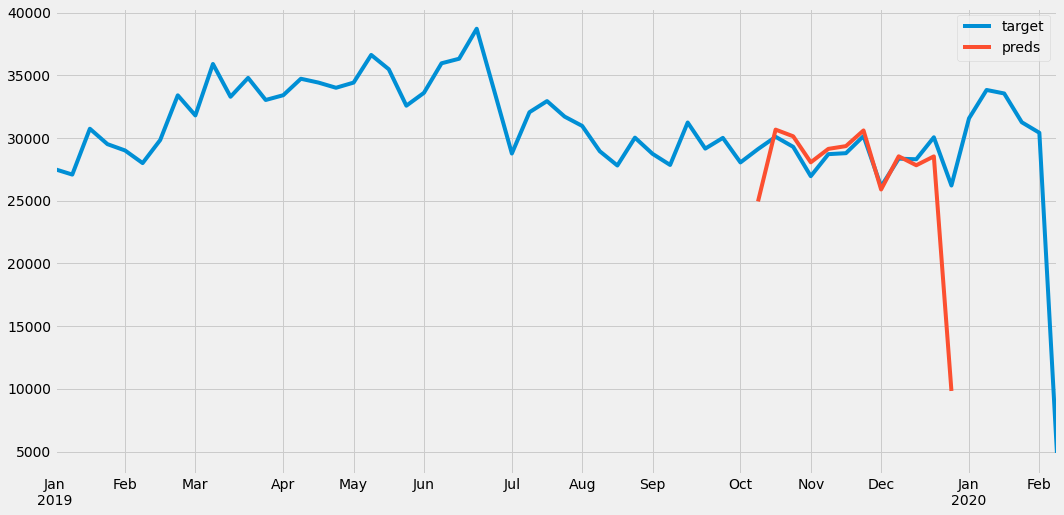

In [36]:
ax = gas_df.resample('1W').sum().plot(figsize=(16, 8))
preds_gas_df.resample('1W').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

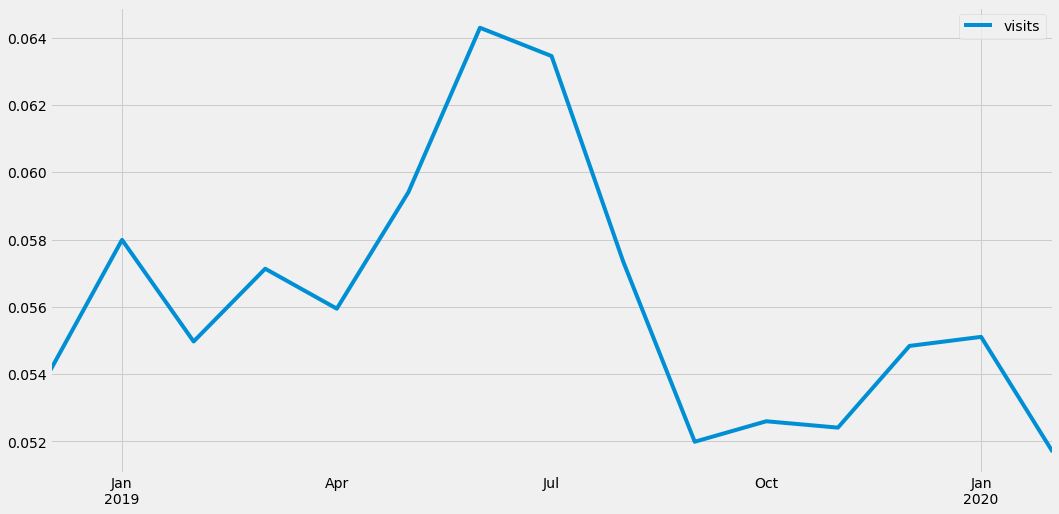

In [37]:
pd.DataFrame(gas_df['visits'] / total_visits_df['visits']).resample('1M').mean().plot(figsize=(16, 8))

### Checking Schools' Visit Patterns

In [38]:
sch_df = get_df_timeseries(agg_df, 'Elementary and Secondary Schools')
sch_df

,visits
2018-12-31 00:00:00,7
2018-12-31 01:00:00,10
2018-12-31 02:00:00,11
2018-12-31 03:00:00,4
2018-12-31 04:00:00,7
...,...
2020-02-03 19:00:00,98
2020-02-03 20:00:00,37
2020-02-03 21:00:00,25
2020-02-03 22:00:00,20


In [39]:
preds_sch_df = get_preds_timeseries(preds_agg_df, 'Elementary and Secondary Schools', valid_dates)
preds_sch_df

,visits
2019-10-08 00:00:00,10.461391
2019-10-08 01:00:00,32.454507
2019-10-08 02:00:00,16.696791
2019-10-08 03:00:00,17.732363
2019-10-08 04:00:00,2.100089
...,...
2019-12-25 14:00:00,77.204758
2019-12-25 15:00:00,59.550284
2019-12-25 16:00:00,42.041989
2019-12-25 17:00:00,28.946692


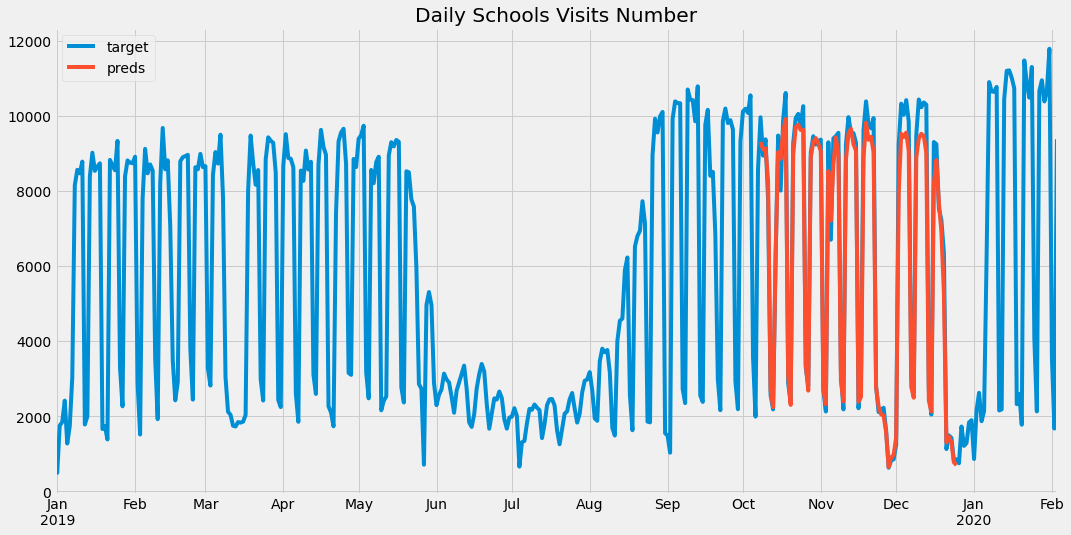

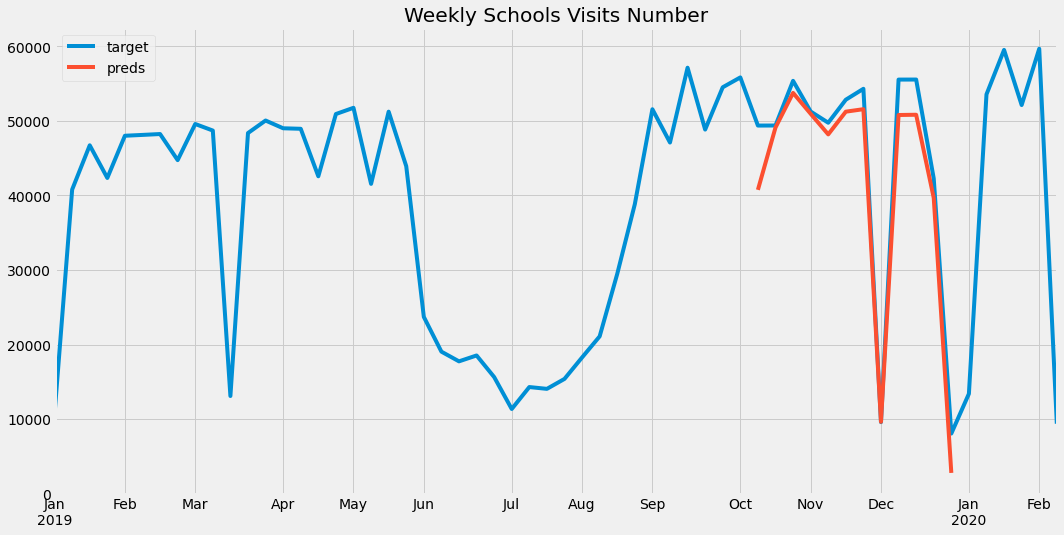

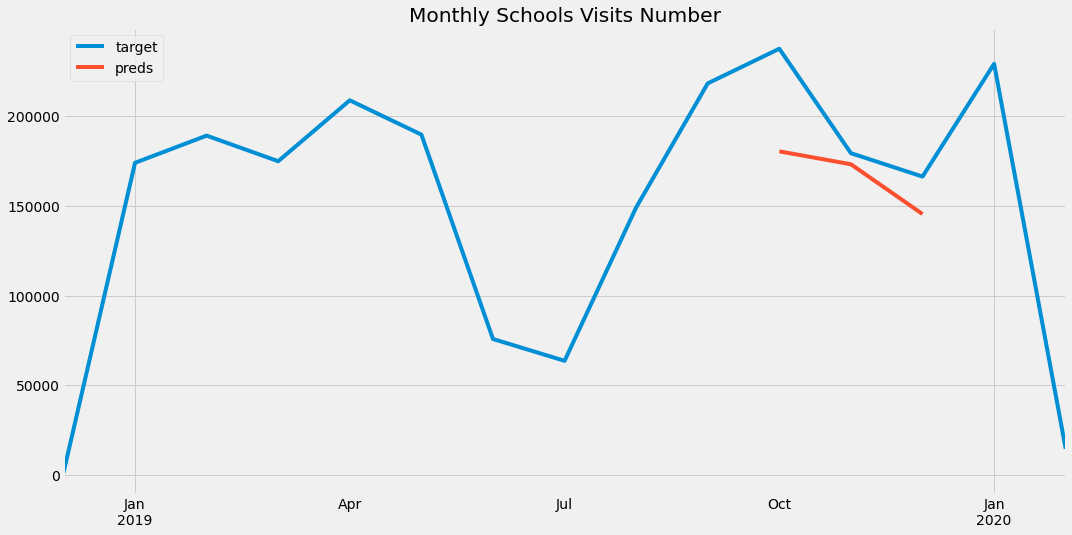

In [40]:
plot_agg_results(sch_df, preds_sch_df, 'Schools')

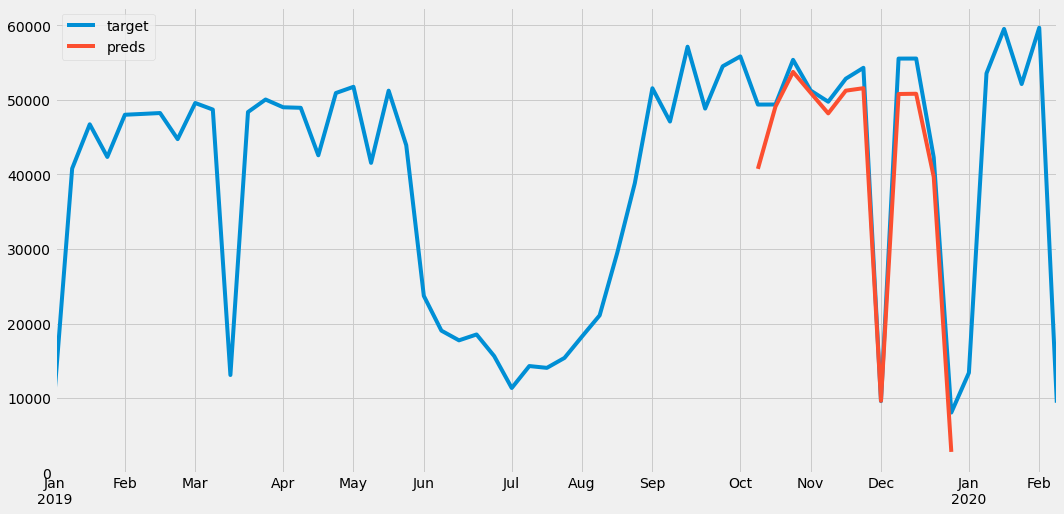

In [41]:
ax = sch_df.resample('1W').sum().plot(figsize=(16, 8))
preds_sch_df.resample('1W').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

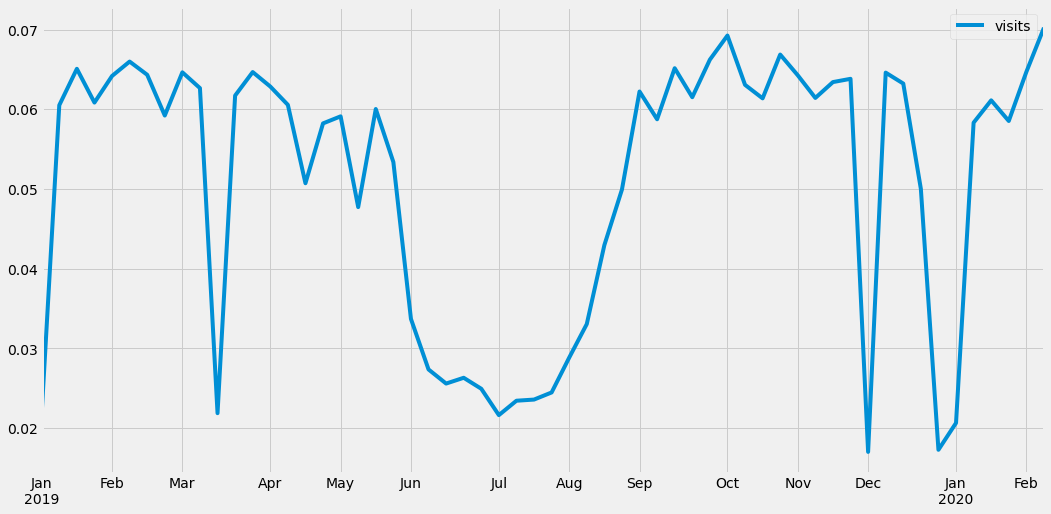

In [43]:
pd.DataFrame(sch_df['visits'] / total_visits_df['visits']).resample('1W').mean().plot(figsize=(16, 8))

### Checking Restaurants' Visit Patterns

In [44]:
rest_df = get_df_timeseries(agg_df, 'Restaurants and Other Eating Places')
rest_df

,visits
2018-12-31 00:00:00,32
2018-12-31 01:00:00,43
2018-12-31 02:00:00,32
2018-12-31 03:00:00,32
2018-12-31 04:00:00,33
...,...
2020-02-03 19:00:00,170
2020-02-03 20:00:00,118
2020-02-03 21:00:00,109
2020-02-03 22:00:00,76


In [45]:
preds_rest_df = get_preds_timeseries(preds_agg_df, 'Restaurants and Other Eating Places', valid_dates)
preds_rest_df

,visits
2019-10-08 00:00:00,43.815592
2019-10-08 01:00:00,44.62498
2019-10-08 02:00:00,49.113777
2019-10-08 03:00:00,53.619511
2019-10-08 04:00:00,68.040847
...,...
2019-12-25 14:00:00,157.973862
2019-12-25 15:00:00,127.005549
2019-12-25 16:00:00,109.015382
2019-12-25 17:00:00,96.596846


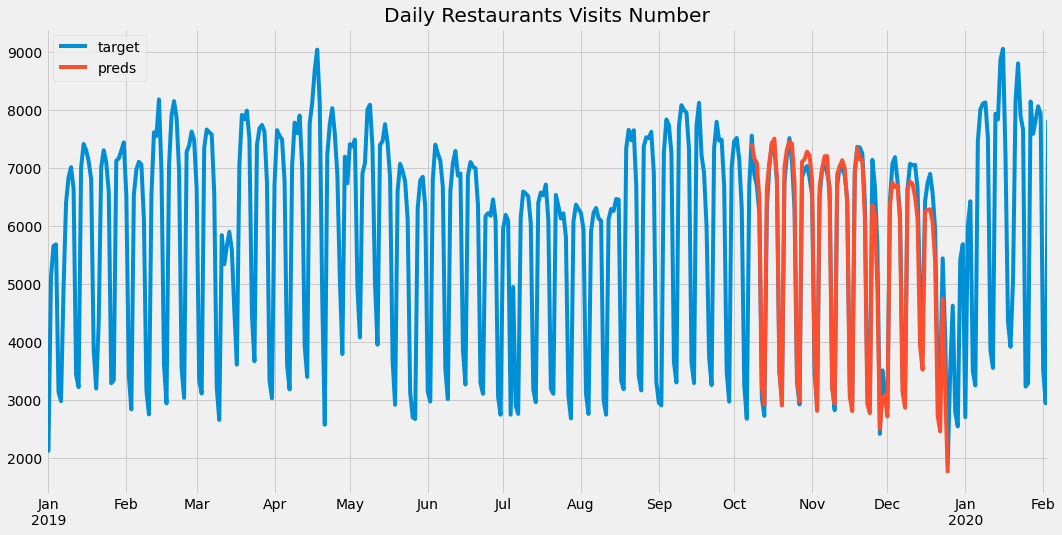

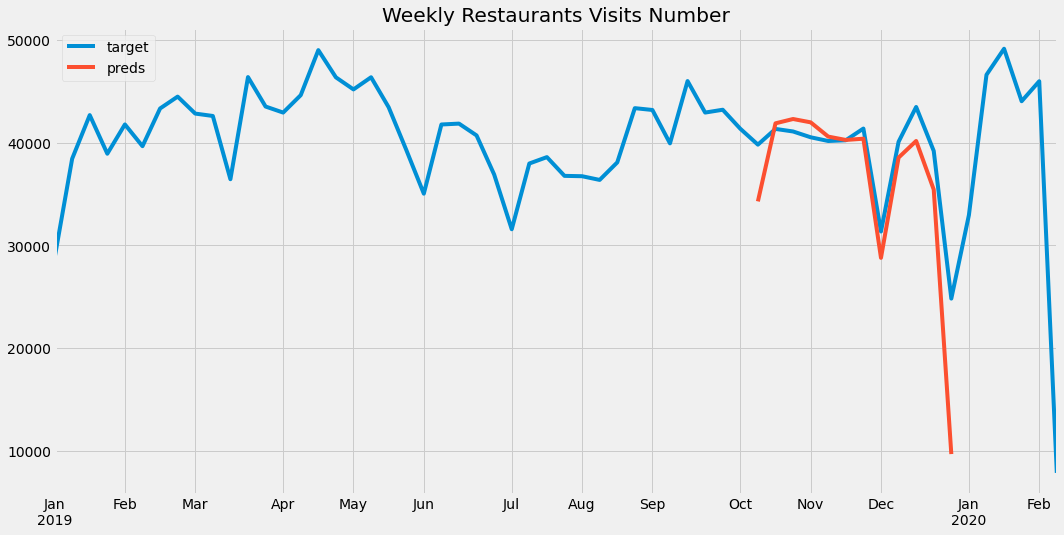

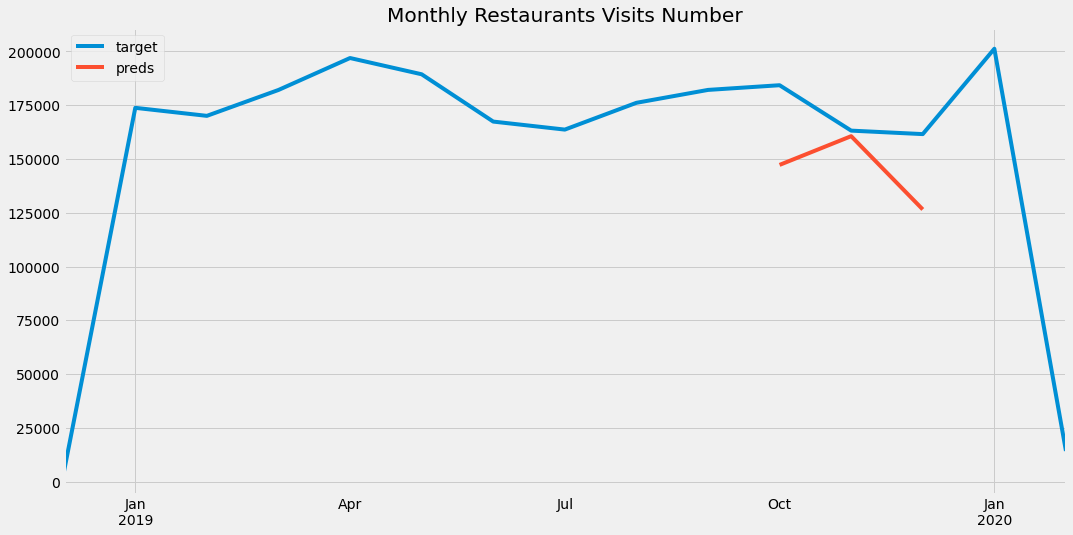

In [46]:
plot_agg_results(rest_df, preds_rest_df, 'Restaurants')

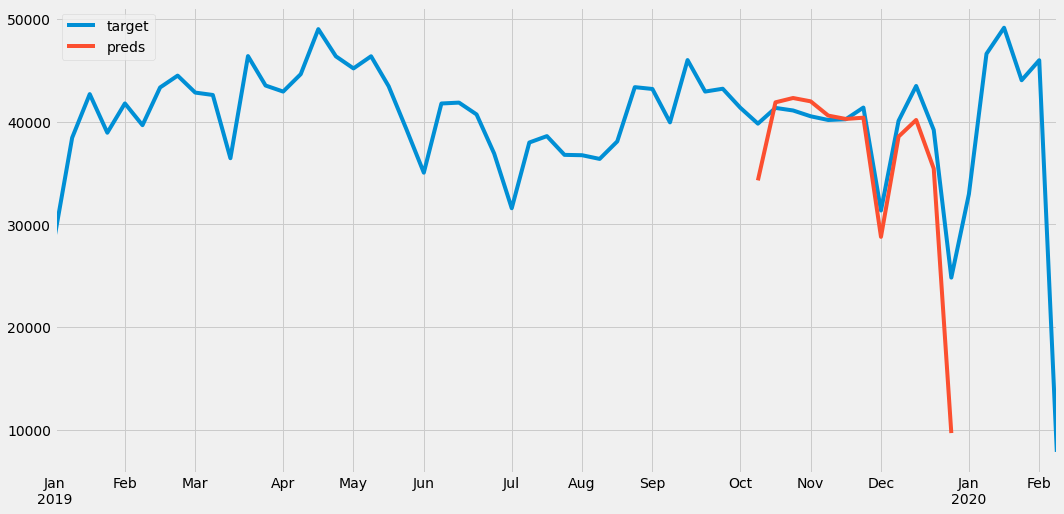

In [47]:
ax = rest_df.resample('1W').sum().plot(figsize=(16, 8))
preds_rest_df.resample('1W').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

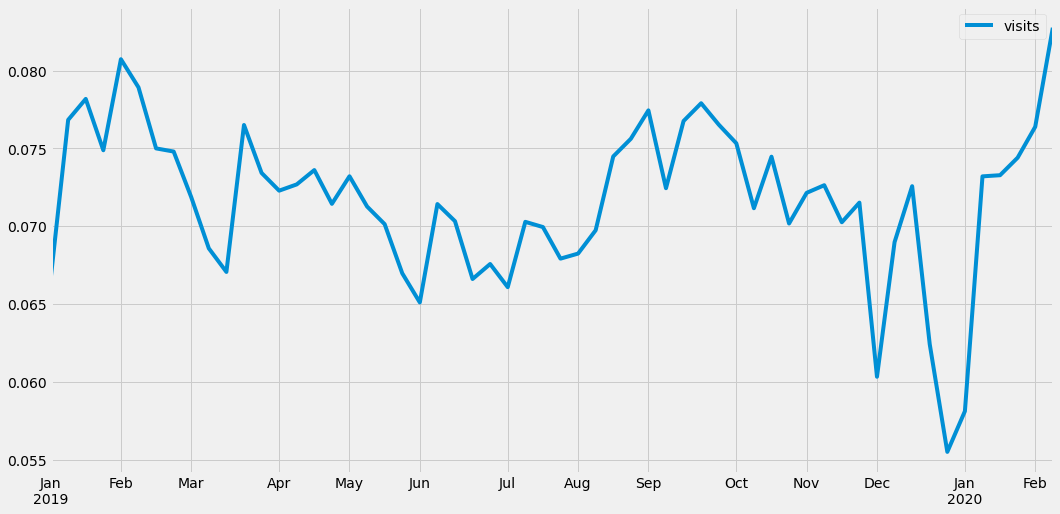

In [48]:
pd.DataFrame(rest_df['visits'] / total_visits_df['visits']).resample('1W').mean().plot(figsize=(16, 8))